## using pret-raind DenseNet169
---
we can try to "fine-tune" the last convolutional block of the DenseNet169 model alongside the top-level classifier.

In [1]:
from keras.applications.densenet import DenseNet169
from keras.layers import Input

input_tensor = Input(shape=(512, 512, 3))

vgg16_model = DenseNet169(weights='imagenet', include_top=False, input_tensor=input_tensor)
vgg16_model.summary()

Using TensorFlow backend.


__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 512, 512, 3)  0                                            
__________________________________________________________________________________________________
zero_padding2d_1 (ZeroPadding2D (None, 518, 518, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1/conv (Conv2D)             (None, 256, 256, 64) 9408        zero_padding2d_1[0][0]           
__________________________________________________________________________________________________
conv1/bn (BatchNormalization)   (None, 256, 256, 64) 256         conv1/conv[0][0]                 
__________________________________________________________________________________________________
conv1/relu

In [2]:
import pandas as pd
data_df = pd.read_csv('../outputs/target_idx.csv')
data_df.head()

,Image Index,Emphysema
0,00000009_000.png,1
1,00000013_041.png,1
2,00000013_042.png,1
3,00000027_000.png,1
4,00000034_000.png,1


In [3]:
from keras.preprocessing.image import ImageDataGenerator

datagen=ImageDataGenerator(rescale=1./255., validation_split=0.1)

img_dir = "../inputs/images/"

train_generator=datagen.flow_from_dataframe(
                            dataframe=data_df,
                            directory=img_dir,
                            x_col="Image Index",
                            y_col="Emphysema",
                            has_ext=True,                                      
                            subset="training",
                            batch_size=32,
                            seed=1,
                            shuffle=True,
                            color_mode = 'rgb',
                            class_mode="binary",
                            target_size=(512, 512))

valid_generator=datagen.flow_from_dataframe(
                            dataframe=data_df,
                            directory=img_dir,
                            x_col="Image Index",
                            y_col="Emphysema",
                            has_ext=True,                                      
                            subset="validation",
                            batch_size=32,
                            seed=1,
                            shuffle=True,
                            color_mode = 'rgb',
                            class_mode="binary",
                            target_size=(512, 512))

Found 1669 images belonging to 2 classes.
Found 223 images belonging to 2 classes.


In [4]:
from keras.models import Sequential, Model
from keras.layers import Conv2D, MaxPooling2D
from keras.layers import Activation, Dropout, Flatten, Dense
from keras import optimizers

In [5]:
top_model = Sequential()
top_model.add(Flatten(input_shape=vgg16_model.output_shape[1:]))
top_model.add(Dense(256, activation='relu'))
top_model.add(Dropout(0.5))
top_model.add(Dense(1, activation='sigmoid'))

model = Model(inputs=vgg16_model.input, outputs=top_model(vgg16_model.output))

In [6]:
for layer in vgg16_model.layers:
    layer.trainable = False

In [7]:
model.compile(loss='binary_crossentropy',
              optimizer=optimizers.SGD(lr=1e-4, momentum=0.9),
              metrics=['accuracy'])

In [8]:
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 512, 512, 3)  0                                            
__________________________________________________________________________________________________
zero_padding2d_1 (ZeroPadding2D (None, 518, 518, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1/conv (Conv2D)             (None, 256, 256, 64) 9408        zero_padding2d_1[0][0]           
__________________________________________________________________________________________________
conv1/bn (BatchNormalization)   (None, 256, 256, 64) 256         conv1/conv[0][0]                 
__________________________________________________________________________________________________
conv1/relu

In [9]:
STEP_SIZE_TRAIN=train_generator.n//train_generator.batch_size
STEP_SIZE_VALID=valid_generator.n//valid_generator.batch_size

history = model.fit_generator(
    generator=train_generator,
    steps_per_epoch=STEP_SIZE_TRAIN,
    validation_data=valid_generator,
    validation_steps=STEP_SIZE_VALID,
    epochs=10)

Epoch 1/10
52/52 [==============================] - 2827s 54s/step - loss: 0.7583 - acc: 0.6202 - val_loss: 0.6676 - val_acc: 0.5677
Epoch 2/10
52/52 [==============================] - 2769s 53s/step - loss: 0.4746 - acc: 0.7534 - val_loss: 0.8310 - val_acc: 0.5497
Epoch 3/10
52/52 [==============================] - 2779s 53s/step - loss: 0.3775 - acc: 0.8451 - val_loss: 0.7234 - val_acc: 0.5288
Epoch 4/10
52/52 [==============================] - 3325s 64s/step - loss: 0.3031 - acc: 0.8714 - val_loss: 0.7591 - val_acc: 0.5864
Epoch 5/10
52/52 [==============================] - 2331s 45s/step - loss: 0.2319 - acc: 0.9050 - val_loss: 0.9670 - val_acc: 0.5183
Epoch 6/10
52/52 [==============================] - 2552s 49s/step - loss: 0.2142 - acc: 0.9247 - val_loss: 0.8044 - val_acc: 0.5812
Epoch 7/10
52/52 [==============================] - 2755s 53s/step - loss: 0.1508 - acc: 0.9499 - val_loss: 1.0441 - val_acc: 0.5288
Epoch 8/10
52/52 [==============================] - 3532s 68s/step - 

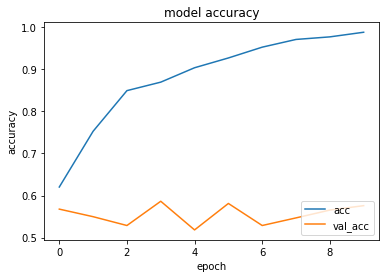

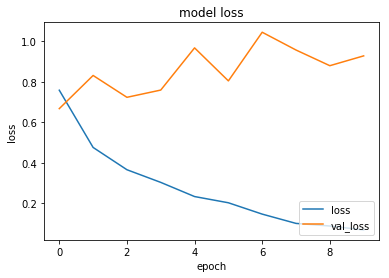

In [10]:
import matplotlib.pyplot as plt
%matplotlib inline

def plot_history(history):
    # print(history.history.keys())

    plt.plot(history.history['acc'])
    plt.plot(history.history['val_acc'])
    plt.title('model accuracy')
    plt.xlabel('epoch')
    plt.ylabel('accuracy')
    plt.legend(['acc', 'val_acc'], loc='lower right')
    plt.show()

    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.legend(['loss', 'val_loss'], loc='lower right')
    plt.show()

plot_history(history)

In [12]:
import numpy as np
np.savez('../plots/Fine-tuning(DenseNet)_train', acc=history.history['acc'], loss=history.history['loss'])
np.savez('../plots/Fine-tuning(DenseNet)_valid', acc=history.history['val_acc'], loss=history.history['val_loss'])